### TensorFlow Linear Regression Model

In [383]:
import pandas as pd
import numpy as np

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)

import nfl_data_py as nfl

**Importing Data**

In [103]:
years = [*range(2018, 2023, 1)]

qb_pass = nfl.import_seasonal_pfr('pass', years)
qbr = nfl.import_qbr(years)

In [104]:
qb_pass

,player,team,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,season,pfr_id,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards
0,Ben Roethlisberger,PIT,675.0,7.0,3.0,24.0,3.6,122.0,18.3,2018,RoetBe00,2.3,164.0,58.0,37.0,119.0,16.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Patrick Mahomes,KC,580.0,24.0,1.0,28.0,5.0,95.0,17.1,2018,MahoPa00,2.4,127.0,121.0,67.0,214.0,33.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Matt Ryan,ATL,608.0,18.0,1.0,36.0,6.1,79.0,13.4,2018,RyanMa00,2.3,201.0,53.0,48.0,143.0,21.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Jared Goff,LAR,561.0,29.0,2.0,13.0,2.5,93.0,17.5,2018,GoffJa00,2.6,151.0,66.0,34.0,133.0,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andrew Luck,IND,639.0,8.0,2.0,37.0,5.9,88.0,14.0,2018,LuckAn00,2.3,154.0,50.0,51.0,119.0,17.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,Christian Kirk,JAX,1.0,0.0,0.0,0.0,0.0,1.0,100.0,2022,KirkCh01,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
537,Cooper Kupp,LAR,1.0,0.0,0.0,0.0,0.0,1.0,100.0,2022,KuppCo00,3.2,0.0,0.0,1.0,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
538,James Proche,BAL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,ProcJa00,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
539,Tommy Townsend,KC,1.0,0.0,0.0,0.0,0.0,1.0,100.0,2022,TownTo01,3.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
qbr

nm = qbr.pop('name_display')
qbr.insert(0, 'name_display', nm)

**Cleaning the Data**

First we will remove QB's with less than 50 pass attempts.

In [106]:
qb_pass = qb_pass.loc[qb_pass['pass_attempts'] > 50]

season = qb_pass.pop('season')
qb_pass.insert(1, 'season', season)

**Combining Regular & Post Season Data**

In [107]:
qb_pass['player_yr'] = qb_pass['player'] + ' ' + qb_pass['season'].astype(str)
qbr['player_yr'] = qbr['name_display'] + ' ' + qbr['season'].astype(str)

In [143]:
players = pd.DataFrame()
player_names = []

for index, row in qbr.iterrows():
    name = row[-1]
    if name not in player_names:
        players = players.append(row, ignore_index=True)
        player_names.append(name)
    else:
        if row['season_type'] == 'Playoffs':
            reg_season = players.loc[players['player_yr'] == name]
            index = players.index[players['player_yr'] == name].tolist()
            
            total_plays = reg_season['qb_plays'] + row['qb_plays']
            
            reg_mult = reg_season['qb_plays'] / total_plays
            playoff_mult = row['qb_plays'] / total_plays
            
            reg_season['season_type'] = 'Regular/Playoffs'
            reg_season['qbr_total'] = reg_season['qbr_total']*reg_mult + row['qbr_total']*playoff_mult
            reg_season['pts_added'] = reg_season['pts_added'] + row['pts_added']
            reg_season['pts_added'] = total_plays
            reg_season['epa_total'] = reg_season['epa_total'] + row['epa_total']
            reg_season['pass'] = reg_season['pass'] + row['pass']
            reg_season['run'] = reg_season['run'] + row['run']
            reg_season['exp_sack'] = reg_season['exp_sack'] + row['exp_sack']
            reg_season['qbr_raw'] = reg_season['qbr_raw']*reg_mult + row['qbr_raw']*playoff_mult
            reg_season['sack'] = reg_season['sack'] + row['sack']
            
            players.loc[index] = reg_season

**Combining Data Frames**

In [144]:
players = players.drop(['season', 'name_short', 'team_abb', 'player_id', 'name_first', 
                        'name_last', 'team', 'qualified', 'headshot_href', 'name_display',
                        'game_week'], axis=1)

In [145]:
qb_df = pd.merge(qb_pass, players, on='player_yr', how='outer')

In [146]:
nm = qb_df.pop('player_yr')
qb_df.insert(0, 'name', nm)

yr = qb_df.pop('season')
qb_df.insert(40, 'season', yr)

qb_df = qb_df.drop(['player', 'pfr_id'], axis=1)
qb_df = qb_df[qb_df['pass_attempts'].notna()]

In [149]:
qb_df

,name,team,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,season_type,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack,season
0,Ben Roethlisberger 2018,PIT,675.0,7.0,3.0,24.0,3.6,122.0,18.3,2.3,164.0,58.0,37.0,119.0,16.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,4.5,69.600000,48.2,762.0,113.5,89.3,8.7,0.0,5.1,71.000000,-10.4,2018.0
1,Patrick Mahomes 2018,KC,580.0,24.0,1.0,28.0,5.0,95.0,17.1,2.4,127.0,121.0,67.0,214.0,33.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,1.0,78.760317,819.0,722.0,138.3,105.5,14.1,0.0,3.2,79.037973,-13.5,2018.0
2,Matt Ryan 2018,ATL,608.0,18.0,1.0,36.0,6.1,79.0,13.4,2.3,201.0,53.0,48.0,143.0,21.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,9.0,65.700000,39.7,722.0,92.9,60.2,7.4,0.0,4.9,68.500000,-20.4,2018.0
3,Jared Goff 2018,LAR,561.0,29.0,2.0,13.0,2.5,93.0,17.5,2.6,151.0,66.0,34.0,133.0,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,10.0,60.158577,787.0,665.0,89.0,66.1,1.7,0.0,4.4,59.999619,-16.7,2018.0
4,Andrew Luck 2018,IND,639.0,8.0,2.0,37.0,5.9,88.0,14.0,2.3,154.0,50.0,51.0,119.0,17.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,4.5,67.967352,827.0,741.0,108.1,87.1,5.7,0.0,4.3,67.465780,-10.7,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Trace McSorley 2022,ARI,83.0,5.0,1.0,2.0,2.6,21.0,27.3,2.2,24.0,5.0,8.0,16.0,17.4,1.0,50.0,64.9,8.0,58.0,7.0,57.0,1.0,1.0,13.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0
258,Joshua Dobbs 2022,TEN,68.0,3.0,0.0,3.0,4.6,14.0,21.5,2.5,25.0,11.0,16.0,33.0,42.9,2.0,43.0,66.2,12.0,94.0,7.0,70.0,4.0,24.0,16.0,125.0,Regular,NaN,52.800000,0.5,86.0,7.8,7.2,0.8,0.0,-0.2,52.200000,-2.1,2022.0
259,David Blough 2022,ARI,58.0,2.0,0.0,2.0,3.6,10.0,17.9,2.2,15.0,0.0,7.0,12.0,18.5,0.0,43.0,76.8,16.0,188.0,15.0,188.0,0.0,0.0,14.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0
260,John Wolford 2022,LAR,62.0,1.0,0.0,1.0,1.6,10.0,16.4,2.7,19.0,7.0,14.0,28.0,37.8,2.0,50.0,82.0,8.0,44.0,8.0,44.0,0.0,0.0,24.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0


In [153]:
wins = pd.read_csv('team_wins.csv')
wins

,team,year,wins,losses,ties,pct,net_pts,pick,playoffs,wildcard,divisional,conf_champ,superbowl
0,KC,2022,14,3,0,0.824,127,32,1,1,1,1,1
1,PHI,2022,14,3,0,0.824,133,31,1,1,1,1,0
2,BUF,2022,13,3,0,0.813,169,28,1,1,0,0,0
3,MIN,2022,13,4,0,0.765,-3,24,1,0,0,0,0
4,SF,2022,13,4,0,0.765,173,30,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,TB,2018,5,11,0,0.313,-68,5,0,0,0,0,0
156,LV,2018,4,12,0,0.250,-177,4,0,0,0,0,0
157,NYJ,2018,4,12,0,0.250,-108,3,0,0,0,0,0
158,SF,2018,4,12,0,0.250,-93,2,0,0,0,0,0


In [162]:
wins['team_yr'] = wins['team'] + ' ' + wins['year'].astype(str)
qb_df['team_yr'] = qb_df['team'] + ' ' + qb_df['season'].astype(str).str[:-2]

In [161]:
qb_df

,name,team,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,season_type,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack,season,team_yr
0,Ben Roethlisberger 2018,PIT,675.0,7.0,3.0,24.0,3.6,122.0,18.3,2.3,164.0,58.0,37.0,119.0,16.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,4.5,69.600000,48.2,762.0,113.5,89.3,8.7,0.0,5.1,71.000000,-10.4,2018.0,PIT 2018
1,Patrick Mahomes 2018,KC,580.0,24.0,1.0,28.0,5.0,95.0,17.1,2.4,127.0,121.0,67.0,214.0,33.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,1.0,78.760317,819.0,722.0,138.3,105.5,14.1,0.0,3.2,79.037973,-13.5,2018.0,KC 2018
2,Matt Ryan 2018,ATL,608.0,18.0,1.0,36.0,6.1,79.0,13.4,2.3,201.0,53.0,48.0,143.0,21.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,9.0,65.700000,39.7,722.0,92.9,60.2,7.4,0.0,4.9,68.500000,-20.4,2018.0,ATL 2018
3,Jared Goff 2018,LAR,561.0,29.0,2.0,13.0,2.5,93.0,17.5,2.6,151.0,66.0,34.0,133.0,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,10.0,60.158577,787.0,665.0,89.0,66.1,1.7,0.0,4.4,59.999619,-16.7,2018.0,LAR 2018
4,Andrew Luck 2018,IND,639.0,8.0,2.0,37.0,5.9,88.0,14.0,2.3,154.0,50.0,51.0,119.0,17.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,4.5,67.967352,827.0,741.0,108.1,87.1,5.7,0.0,4.3,67.465780,-10.7,2018.0,IND 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Trace McSorley 2022,ARI,83.0,5.0,1.0,2.0,2.6,21.0,27.3,2.2,24.0,5.0,8.0,16.0,17.4,1.0,50.0,64.9,8.0,58.0,7.0,57.0,1.0,1.0,13.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,ARI 2022
258,Joshua Dobbs 2022,TEN,68.0,3.0,0.0,3.0,4.6,14.0,21.5,2.5,25.0,11.0,16.0,33.0,42.9,2.0,43.0,66.2,12.0,94.0,7.0,70.0,4.0,24.0,16.0,125.0,Regular,NaN,52.800000,0.5,86.0,7.8,7.2,0.8,0.0,-0.2,52.200000,-2.1,2022.0,TEN 2022
259,David Blough 2022,ARI,58.0,2.0,0.0,2.0,3.6,10.0,17.9,2.2,15.0,0.0,7.0,12.0,18.5,0.0,43.0,76.8,16.0,188.0,15.0,188.0,0.0,0.0,14.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,ARI 2022
260,John Wolford 2022,LAR,62.0,1.0,0.0,1.0,1.6,10.0,16.4,2.7,19.0,7.0,14.0,28.0,37.8,2.0,50.0,82.0,8.0,44.0,8.0,44.0,0.0,0.0,24.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,LAR 2022


In [268]:
qb_winpct = pd.merge(qb_df,wins[['team_yr', 'pct']], on='team_yr')
qb_playoff = pd.merge(qb_df,wins[['team_yr', 'playoffs']], on='team_yr')
qb_sb = pd.merge(qb_df,wins[['team_yr', 'superbowl']], on='team_yr')

In [425]:
qb_full = pd.merge(qb_df, wins, on='team_yr')
qb_full.to_csv('qb_full.csv', index=True)

In [269]:
qb_sb = qb_sb.fillna(qb_sb.median())
qb_playoff = qb_playoff.fillna(qb_playoff.median())
qb_winpct = qb_winpct.fillna(qb_winpct.median())

**Standardizing Variables**

In [245]:
target_winpct = qb_winpct[['pct']]
data_winpct = qb_winpct.drop(['pct'], axis=1)

data_winpct = data_winpct.set_index('name')
data_winpct.drop(['team', 'season_type', 'season', 'team_yr'], axis=1, inplace=True)

In [246]:
predictors = []

for col in data_winpct.columns:
    predictors.append(col)

In [247]:
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

PredictorScalerFit=PredictorScaler.fit(data_winpct)
TargetVarScalerFit=TargetVarScaler.fit(target_winpct)

data_winpct=PredictorScalerFit.transform(data_winpct)
target_winpct=TargetVarScalerFit.transform(target_winpct)

In [248]:
data_winpct

array([[ 1.72689039, -0.4956338 ,  1.11921972, ...,  1.63545355,
         1.32012681,  0.49993609],
       [ 1.2449071 ,  1.45883812, -0.2061034 , ...,  0.3626429 ,
         2.0786316 , -0.18658236],
       [ 1.38696533,  0.7690245 , -0.2061034 , ...,  1.50147348,
         1.08421386, -1.71463954],
       ...,
       [-0.72868762, -0.61060274, -0.86876496, ..., -0.0392973 ,
         0.06506989,  0.01272945],
       [-0.98743654,  0.88399344,  1.11921972, ..., -0.0392973 ,
         0.06506989,  0.01272945],
       [-1.15993582, -1.18544742, -0.86876496, ..., -0.0392973 ,
         0.06506989,  0.01272945]])

**Creating the Model**

In [249]:
x_train, x_test, y_train, y_test = train_test_split(data_winpct, target_winpct, test_size=0.25)

In [250]:
x_test.shape

(64, 35)

**Tuning Hyperparameters**

In [251]:
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    TrialNumber=0
    
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            model = Sequential()
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
            model.add(Dense(1, kernel_initializer='normal'))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))

            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)

In [252]:
results = FunctionFindBestParams(x_train, y_train, x_test, y_test)

2/2 [==============================] - 0s 797us/step
1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 55.41750262003747
2/2 [==============================] - 0s 966us/step
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 24.548663920142104
2/2 [==============================] - 0s 1ms/step
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: -35.798847590935935
2/2 [==============================] - 0s 931us/step
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: -38.21059577356715
2/2 [==============================] - 0s 996us/step
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 96.49772526830728
2/2 [==============================] - 0s 1ms/step
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 42.592263403583445
2/2 [==============================] - 0s 884us/step
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 42.5372461845734
2/2 [==============================] - 0s 1ms/step
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: -42.45434585853201
2/2 [================

<Axes: xlabel='Parameters'>

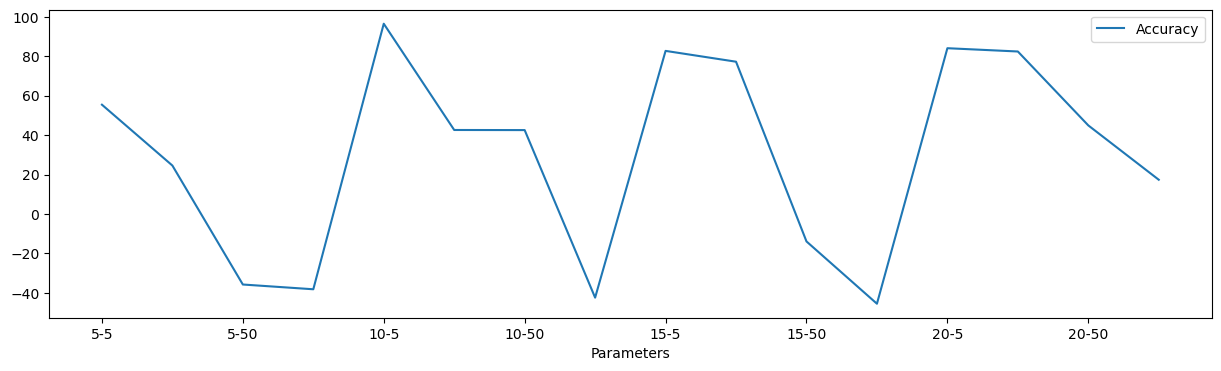

In [253]:
%matplotlib inline
results.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

The best hyperparameters are batch_size = 10 and epochs = 5.

In [254]:
model = Sequential()

model.add(Dense(units=5, input_dim=35, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='normal'))
 
model.compile(loss='mean_squared_error', optimizer='adam')
 
model.fit(x_train, y_train, batch_size = 10, epochs = 5, verbose=0)

In [255]:
y_pred=model.predict(x_test)

2/2 [==============================] - 0s 1ms/step


In [257]:
pred=TargetVarScalerFit.inverse_transform(y_pred)
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

Test_Data=PredictorScalerFit.inverse_transform(x_test)

TestingData=pd.DataFrame(data=Test_Data, columns=predictors)
TestingData['winpct']=y_test_orig
TestingData['pred_win']=pred
TestingData.head()

,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack,winpct,pred_win
0,558.0,25.0,8.0,13.0,2.5,88.0,16.8,2.4,156.0,55.0,24.0,106.0,16.7,14.0,405.0,77.1,171.0,1395.0,121.0,1107.0,43.0,288.0,107.0,877.0,14.0,61.90000,24.7,763.0,99.9,64.5,32.3,0.0,3.1,61.300000,-11.8,0.500,0.517868
1,569.0,31.0,1.0,24.0,4.5,114.0,21.2,2.6,154.0,57.0,45.0,138.0,21.9,3.0,401.0,74.7,32.0,107.0,30.0,107.0,0.0,0.0,124.0,966.0,20.0,53.59987,771.0,691.0,73.1,43.6,8.9,0.0,1.1,56.222568,-18.7,0.813,0.484045
2,58.0,2.0,0.0,2.0,3.6,10.0,17.9,2.2,15.0,0.0,7.0,12.0,18.5,0.0,43.0,76.8,16.0,188.0,15.0,188.0,0.0,0.0,14.0,166.0,16.0,57.50000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6,0.235,0.448981
3,89.0,2.0,0.0,5.0,5.7,16.0,18.4,2.4,21.0,16.0,4.0,33.0,30.8,5.0,244.0,75.3,21.0,147.0,18.0,121.0,1.0,3.0,68.0,542.0,16.0,57.50000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6,0.250,0.448774
4,276.0,6.0,0.0,16.0,5.9,54.0,20.0,2.3,84.0,15.0,29.0,70.0,22.3,8.0,192.0,71.1,39.0,221.0,34.0,215.0,2.0,6.0,65.0,431.0,30.0,34.40000,-14.3,352.0,14.1,9.8,3.5,0.0,0.7,36.000000,-11.4,0.500,0.434835


**Accuracy**

In [258]:
APE=100*(abs(TestingData['winpct']-TestingData['pred_win'])/TestingData['winpct'])
TestingData['APE']=APE

In [259]:
TestingData.head()

,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack,winpct,pred_win,APE
0,558.0,25.0,8.0,13.0,2.5,88.0,16.8,2.4,156.0,55.0,24.0,106.0,16.7,14.0,405.0,77.1,171.0,1395.0,121.0,1107.0,43.0,288.0,107.0,877.0,14.0,61.90000,24.7,763.0,99.9,64.5,32.3,0.0,3.1,61.300000,-11.8,0.500,0.517868,3.573525
1,569.0,31.0,1.0,24.0,4.5,114.0,21.2,2.6,154.0,57.0,45.0,138.0,21.9,3.0,401.0,74.7,32.0,107.0,30.0,107.0,0.0,0.0,124.0,966.0,20.0,53.59987,771.0,691.0,73.1,43.6,8.9,0.0,1.1,56.222568,-18.7,0.813,0.484045,40.461895
2,58.0,2.0,0.0,2.0,3.6,10.0,17.9,2.2,15.0,0.0,7.0,12.0,18.5,0.0,43.0,76.8,16.0,188.0,15.0,188.0,0.0,0.0,14.0,166.0,16.0,57.50000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6,0.235,0.448981,91.055625
3,89.0,2.0,0.0,5.0,5.7,16.0,18.4,2.4,21.0,16.0,4.0,33.0,30.8,5.0,244.0,75.3,21.0,147.0,18.0,121.0,1.0,3.0,68.0,542.0,16.0,57.50000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6,0.250,0.448774,79.509771
4,276.0,6.0,0.0,16.0,5.9,54.0,20.0,2.3,84.0,15.0,29.0,70.0,22.3,8.0,192.0,71.1,39.0,221.0,34.0,215.0,2.0,6.0,65.0,431.0,30.0,34.40000,-14.3,352.0,14.1,9.8,3.5,0.0,0.7,36.000000,-11.4,0.500,0.434835,13.033020


In [260]:
print('The Accuracy of ANN model is:', 100-np.mean(APE))

The Accuracy of ANN model is: 43.06432984670445


**Logistic Regression Models**

In [399]:
target_playoff = qb_playoff[['playoffs']]
data_playoff = qb_playoff.drop(['playoffs'], axis=1)

data_playoff = data_playoff.set_index('name')
data_playoff.drop(['team', 'season_type', 'season', 'team_yr'], axis=1, inplace=True)

In [400]:
x_train, x_test, y_train, y_test = train_test_split(data_playoff, target_playoff, test_size=0.25)

In [401]:
x_train

,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ryan Tannehill 2019,286.0,5.0,3.0,9.0,3.2,35.0,12.6,2.6,104.0,25.0,24.0,80.0,24.1,6.0,225.0,80.9,7.0,90.0,5.0,85.0,2.0,5.0,74.0,1095.0,9.0,65.022609,460.0,374.0,54.1,22.7,11.6,0.0,2.3,65.592174,-15.8
Cam Newton 2019,89.0,2.0,1.0,3.0,3.5,26.0,30.2,2.2,43.0,12.0,5.0,23.0,24.0,2.0,54.0,62.8,15.0,116.0,12.0,116.0,2.0,0.0,22.0,195.0,16.0,57.500000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6
Marcus Mariota 2019,160.0,9.0,2.0,10.0,6.7,31.0,20.8,2.4,57.0,23.0,12.0,60.0,30.3,2.0,107.0,71.8,19.0,165.0,14.0,147.0,5.0,18.0,42.0,473.0,16.0,90.500000,0.2,2.0,0.4,0.2,0.2,0.0,0.0,85.400000,0.0
John Wolford 2022,62.0,1.0,0.0,1.0,1.6,10.0,16.4,2.7,19.0,7.0,14.0,28.0,37.8,2.0,50.0,82.0,8.0,44.0,8.0,44.0,0.0,0.0,24.0,199.0,16.0,57.500000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6
Kyler Murray 2019,542.0,24.0,4.0,17.0,3.3,92.0,17.9,2.3,151.0,63.0,16.0,127.0,20.6,18.0,378.0,73.5,108.0,780.0,70.0,536.0,33.0,244.0,116.0,938.0,15.0,57.700000,16.2,709.0,71.6,37.3,13.4,0.0,3.0,58.000000,-17.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sam Ehlinger 2022,101.0,1.0,0.0,6.0,6.0,18.0,18.0,2.5,23.0,8.0,7.0,29.0,23.0,2.0,74.0,74.0,12.0,100.0,10.0,97.0,1.0,3.0,22.0,156.0,16.0,57.500000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6
Dak Prescott 2022,394.0,6.0,0.0,24.0,6.2,67.0,17.3,2.5,102.0,29.0,37.0,86.0,20.0,4.0,296.0,76.3,46.0,324.0,40.0,288.0,5.0,36.0,94.0,663.0,12.0,63.390265,565.0,480.0,69.2,57.1,9.5,0.0,2.7,64.196460,-9.1
Colt McCoy 2018,54.0,0.0,2.0,0.0,0.0,7.0,13.5,2.3,6.0,8.0,3.0,17.0,25.4,5.0,244.0,75.3,21.0,147.0,18.0,121.0,1.0,3.0,68.0,542.0,16.0,57.500000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6


In [402]:
logreg = LogisticRegression(random_state=16)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

In [403]:
cnf = metrics.confusion_matrix(y_test, y_pred)
cnf

array([[33,  5],
       [ 5, 21]])

In [404]:
coeff = logreg.coef_[0]
coeff

array([ 0.00024755, -0.14876458, -0.06629709,  0.03828058,  0.04424749,
        0.0088441 , -0.04037723, -0.00682658, -0.01879123,  0.00745857,
       -0.02207128,  0.01818745, -0.05448767, -0.02276872, -0.01318688,
        0.11090729, -0.0449075 ,  0.00843912,  0.00771789,  0.00494568,
       -0.01954884,  0.00297743,  0.03551525, -0.00185903, -0.07710717,
       -0.00983554,  0.05536719, -0.00103221, -0.03007438, -0.02606213,
       -0.13249484,  0.        ,  0.00715129, -0.05283303, -0.01833072])

<Axes: ylabel='Feature'>

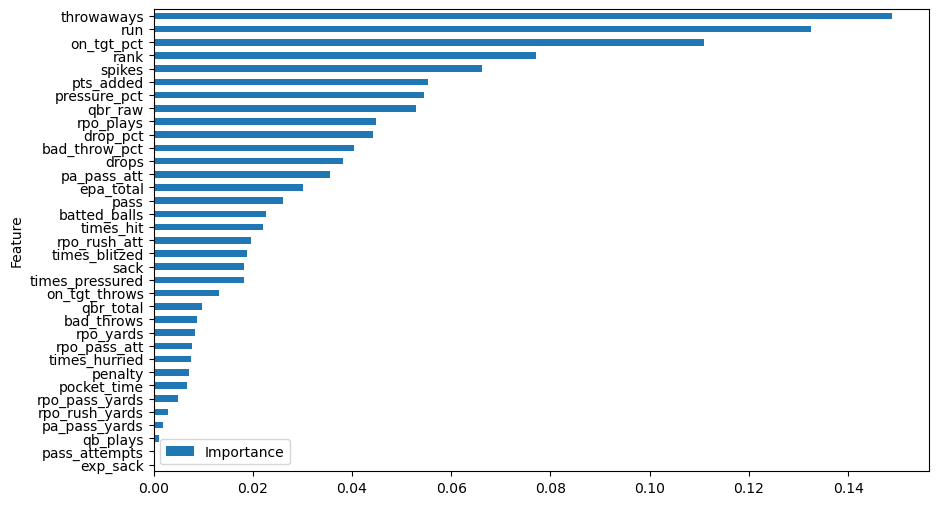

In [405]:
feature_importance = pd.DataFrame({'Feature': data_playoff.columns, 'Importance': np.abs(coeff)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [406]:
feature_importance.to_csv('playoff_feature_importance.csv')

In [407]:
pca = PCA()
pca.fit(x_train)

PCA()

In [408]:
pca_final = PCA(0.95)
playoff_train_pca = pca_final.fit_transform(x_train)
playoff_test_pca = pca_final.transform(x_test)

In [409]:
y_test_df

,playoffs,ID
0,0,239
1,1,216
2,1,232
3,1,11
4,0,238
...,...,...
59,0,249
60,0,196
61,0,138
62,1,125


In [410]:
n_components = len(pca_final.explained_variance_ratio_)
explained_variance = pca_final.explained_variance_ratio_

In [411]:
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1

In [412]:
df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

In [413]:
mean_explained_variance = df_explained_variance.iloc[:,0].mean()

In [414]:
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

PCA Overview
Total: 4 components
----------------------------------------
Mean explained variance: 0.238
----------------------------------------
   explained variance  cumulative
1            0.648794    0.648794
2            0.139941    0.788736
3            0.122195    0.910931
4            0.042295    0.953226
----------------------------------------


Limit scree plot to nth component (0 for all) >  0


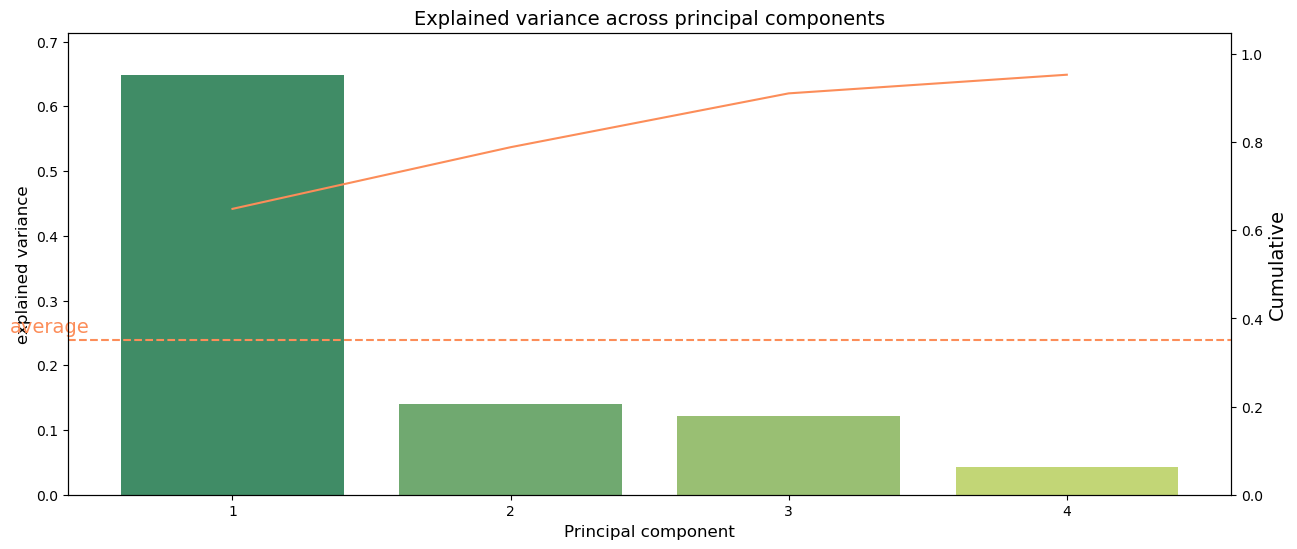

In [416]:
limit = int(input("Limit scree plot to nth component (0 for all) > "))
if limit > 0:
    limit_df = limit
else:
    limit_df = n_components
df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]
#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')
ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis
max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))
plt.show()

In [417]:
df_explained_variance

,explained variance,cumulative
1,0.648794,0.648794
2,0.139941,0.788736
3,0.122195,0.910931
4,0.042295,0.953226


In [418]:
pcf = pd.DataFrame(pca_final.components_.T, columns = ['PC1', 'PC2', 'PC3', 'PC4'],
                   index=predictors)

<Axes: >

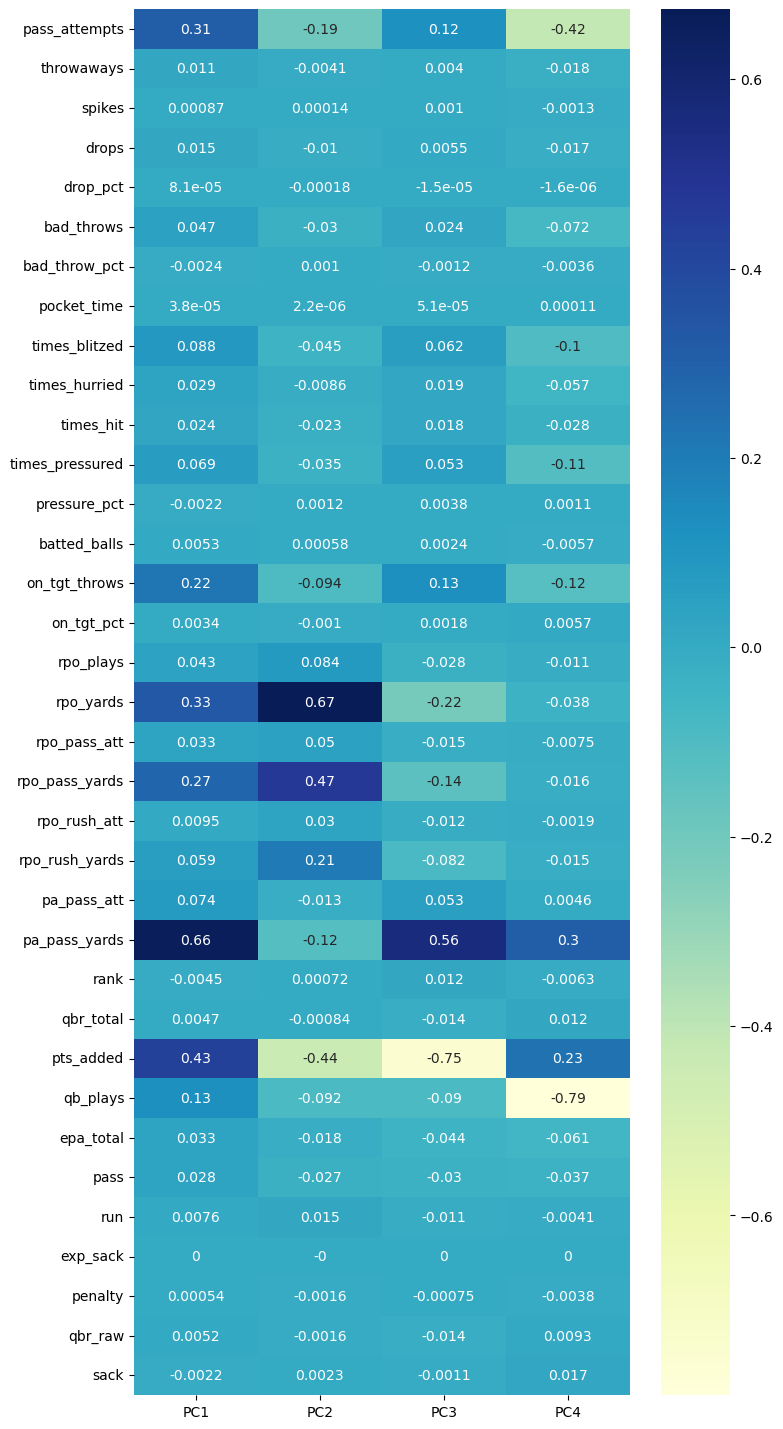

In [419]:
size_yaxis = round(x_train.shape[1] * 0.5)
fig, ax = plt.subplots(figsize=(8,size_yaxis))

sns.heatmap(pcf, annot=True, cmap='YlGnBu')

**Assessing the Model**

In [420]:
logreg.fit(playoff_train_pca, y_train)

LogisticRegression(random_state=16)

In [421]:
y_pred = logreg.predict(playoff_test_pca)

In [422]:
target_names = ['Playoff Berth', 'Missed Playoffs']
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

  Playoff Berth       0.88      0.92      0.90        38
Missed Playoffs       0.88      0.81      0.84        26

       accuracy                           0.88        64
      macro avg       0.88      0.86      0.87        64
   weighted avg       0.88      0.88      0.87        64



**Superbowl Model**

In [365]:
target_sb = qb_sb[['superbowl']]
data_sb = qb_sb.drop(['superbowl'], axis=1)

data_sb = data_sb.set_index('name')
data_sb.drop(['team', 'season_type', 'season', 'team_yr'], axis=1, inplace=True)

In [366]:
x_train, x_test, y_train, y_test = train_test_split(data_sb, target_sb, test_size=0.25)

In [367]:
x_train

,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Rodgers 2022,542.0,25.0,2.0,40.0,7.8,76.0,14.8,2.4,136.0,37.0,39.0,108.0,18.4,8.0,415.0,80.6,62.0,417.0,58.0,413.0,1.0,4.0,136.0,994.0,26.0,41.300000,-10.6,624.0,42.6,36.5,2.4,0.0,3.7,44.000000,-16.4
Mike Glennon 2020,179.0,5.0,3.0,7.0,4.1,25.0,14.6,2.3,32.0,10.0,12.0,31.0,16.1,3.0,123.0,71.9,3.0,6.0,2.0,6.0,0.0,0.0,26.0,267.0,16.0,57.500000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6
Josh Allen 2021,646.0,32.0,0.0,35.0,5.7,107.0,17.4,2.4,182.0,95.0,64.0,185.0,25.7,16.0,459.0,74.8,124.0,916.0,93.0,762.0,31.0,154.0,178.0,1643.0,6.0,68.960373,911.0,828.0,134.6,98.0,36.4,0.0,0.3,69.996597,-11.4
Russell Wilson 2019,516.0,20.0,3.0,17.0,3.4,91.0,18.5,2.5,221.0,71.0,57.0,176.0,28.9,9.0,376.0,76.3,51.0,377.0,38.0,344.0,9.0,33.0,117.0,1059.0,5.0,73.592116,761.0,674.0,108.1,68.6,15.6,0.0,1.5,72.880552,-22.8
Carson Wentz 2019,607.0,10.0,1.0,28.0,4.7,106.0,17.8,2.4,184.0,67.0,53.0,157.0,23.4,16.0,431.0,72.3,79.0,447.0,68.0,396.0,7.0,51.0,149.0,1062.0,11.0,62.339015,751.0,745.0,89.9,60.4,7.7,0.0,5.8,64.329427,-15.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Josh McCown 2018,110.0,3.0,1.0,7.0,6.6,24.0,22.6,2.3,47.0,8.0,14.0,29.0,23.8,5.0,244.0,75.3,21.0,147.0,18.0,121.0,1.0,3.0,68.0,542.0,16.0,57.500000,15.3,585.0,57.1,39.8,5.1,0.0,2.6,57.700000,-12.6
Carson Wentz 2022,276.0,6.0,0.0,16.0,5.9,54.0,20.0,2.3,84.0,15.0,29.0,70.0,22.3,8.0,192.0,71.1,39.0,221.0,34.0,215.0,2.0,6.0,65.0,431.0,30.0,34.400000,-14.3,352.0,14.1,9.8,3.5,0.0,0.7,36.000000,-11.4
Patrick Mahomes 2019,484.0,19.0,0.0,25.0,5.4,85.0,18.3,2.5,108.0,54.0,34.0,105.0,20.0,6.0,359.0,77.2,71.0,497.0,64.0,469.0,6.0,28.0,115.0,908.0,2.0,80.001774,733.0,585.0,129.9,92.5,20.8,0.0,5.0,81.439291,-8.5


**Base Log Model**

In [368]:
logreg = LogisticRegression(random_state=16)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

In [369]:
cnf = metrics.confusion_matrix(y_test, y_pred)
cnf

array([[62,  0],
       [ 1,  1]])

In [370]:
coeff_sb = logreg.coef_[0]

**Feature Importance**

<Axes: ylabel='Feature'>

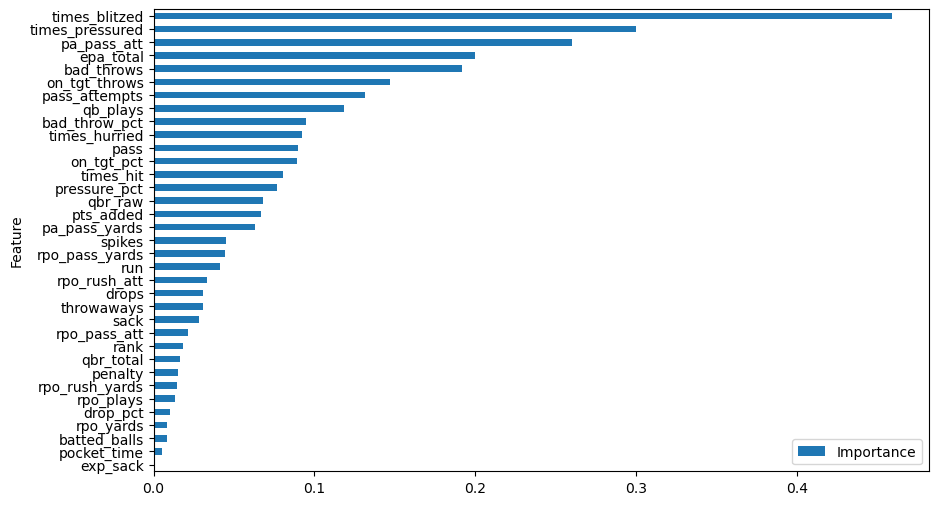

In [371]:
feature_importance = pd.DataFrame({'Feature': data_sb.columns, 'Importance': np.abs(coeff_sb)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [372]:
feature_importance.to_csv('sb_feature_importance.csv')

**Defining Components**

In [388]:
pca_sb = PCA(0.95)
pca_sb_train = pca_sb.fit_transform(x_train)
pca_sb_test = pca_sb.transform(x_test)

In [374]:
n_components = len(pca_sb.explained_variance_ratio_)
explained_variance = pca_sb.explained_variance_ratio_

In [375]:
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1

In [376]:
df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

In [377]:
mean_explained_variance = df_explained_variance.iloc[:,0].mean()

In [378]:
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

PCA Overview
Total: 4 components
----------------------------------------
Mean explained variance: 0.238
----------------------------------------
   explained variance  cumulative
1            0.638682    0.638682
2            0.141730    0.780412
3            0.121882    0.902293
4            0.051129    0.953423
----------------------------------------


In [379]:
pca_sb.explained_variance_ratio_

array([0.63868167, 0.1417299 , 0.12188166, 0.05112933])

Limit scree plot to nth component (0 for all) >  0


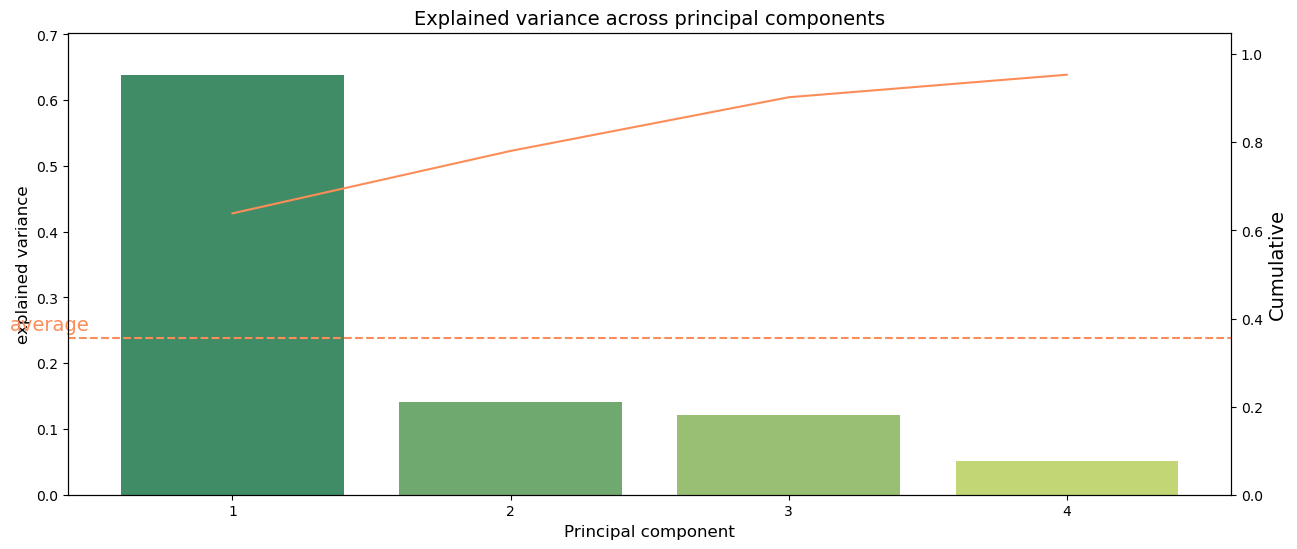

In [380]:
limit = int(input("Limit scree plot to nth component (0 for all) > "))
if limit > 0:
    limit_df = limit
else:
    limit_df = n_components
df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]
#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')
ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis
max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))
plt.show()

**Taking a Closer Look at Components**

In [381]:
pcf = pd.DataFrame(pca_sb.components_.T, columns = ['PC1', 'PC2', 'PC3', 'PC4'],
                   index=predictors)

<Axes: >

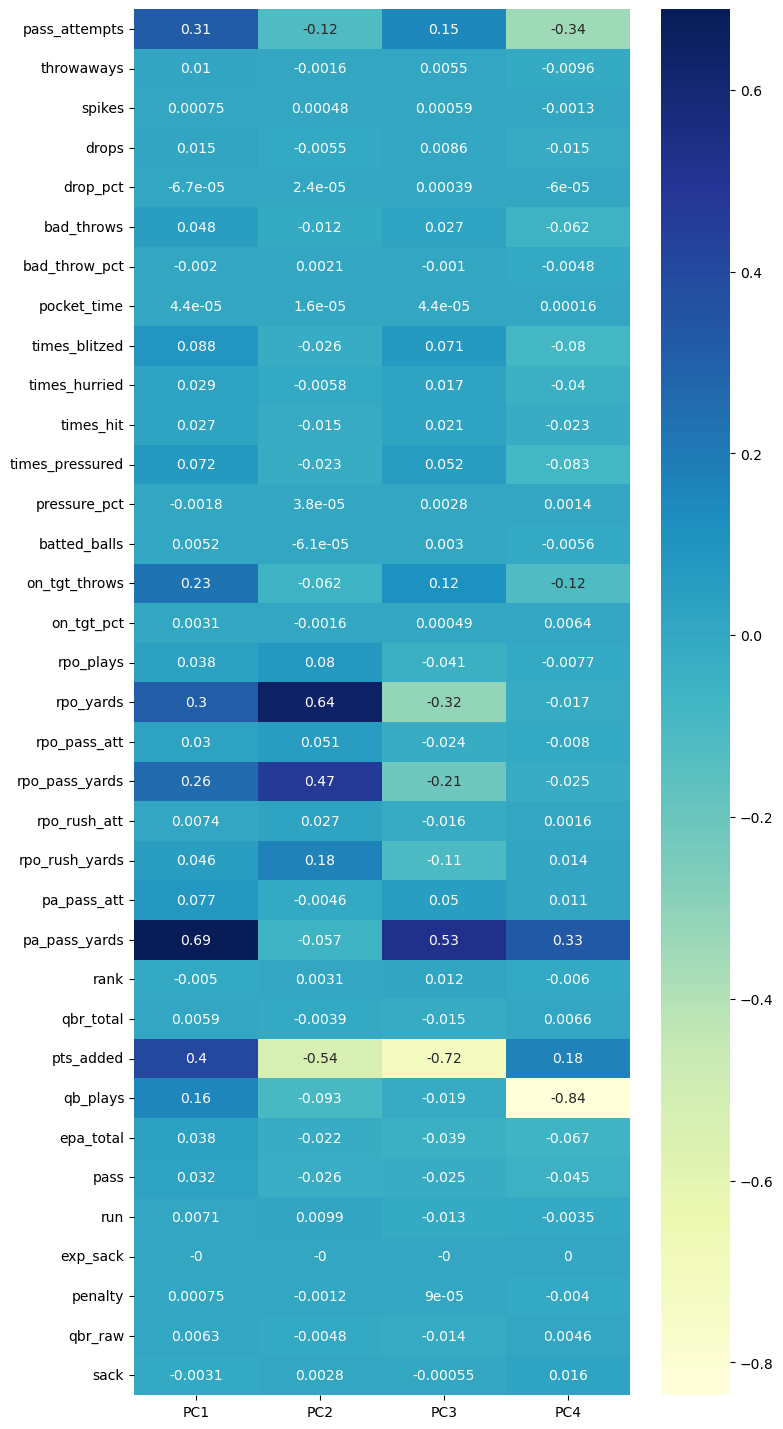

In [382]:
size_yaxis = round(x_train.shape[1] * 0.5)
fig, ax = plt.subplots(figsize=(8,size_yaxis))

sns.heatmap(pcf, annot=True, cmap='YlGnBu')

**Making Predictions**

In [389]:
logreg.fit(pca_sb_train, y_train)

LogisticRegression(random_state=16)

In [390]:
y_pred = logreg.predict(pca_sb_test)

**Assessing the Model**

In [391]:
target_names = ['Superbowl Win', 'No Superbowl Win']
print(classification_report(y_test, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

   Superbowl Win       0.97      1.00      0.98        62
No Superbowl Win       0.00      0.00      0.00         2

        accuracy                           0.97        64
       macro avg       0.48      0.50      0.49        64
    weighted avg       0.94      0.97      0.95        64



In [426]:
qb_full

,name,team_x,pass_attempts,throwaways,spikes,drops,drop_pct,bad_throws,bad_throw_pct,pocket_time,times_blitzed,times_hurried,times_hit,times_pressured,pressure_pct,batted_balls,on_tgt_throws,on_tgt_pct,rpo_plays,rpo_yards,rpo_pass_att,rpo_pass_yards,rpo_rush_att,rpo_rush_yards,pa_pass_att,pa_pass_yards,season_type,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack,season,team_yr,team_y,year,wins,losses,ties,pct,net_pts,pick,playoffs,wildcard,divisional,conf_champ,superbowl
0,Ben Roethlisberger 2018,PIT,675.0,7.0,3.0,24.0,3.6,122.0,18.3,2.3,164.0,58.0,37.0,119.0,16.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,4.5,69.600000,48.2,762.0,113.5,89.3,8.7,0.0,5.1,71.000000,-10.4,2018.0,PIT 2018,PIT,2018,9,6,1,0.594,68,20,0,0,0,0,0
1,Patrick Mahomes 2018,KC,580.0,24.0,1.0,28.0,5.0,95.0,17.1,2.4,127.0,121.0,67.0,214.0,33.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,1.0,78.760317,819.0,722.0,138.3,105.5,14.1,0.0,3.2,79.037973,-13.5,2018.0,KC 2018,KC,2018,12,4,0,0.750,144,29,1,1,1,0,0
2,Matt Ryan 2018,ATL,608.0,18.0,1.0,36.0,6.1,79.0,13.4,2.3,201.0,53.0,48.0,143.0,21.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,9.0,65.700000,39.7,722.0,92.9,60.2,7.4,0.0,4.9,68.500000,-20.4,2018.0,ATL 2018,ATL,2018,7,9,0,0.438,-9,14,0,0,0,0,0
3,Jared Goff 2018,LAR,561.0,29.0,2.0,13.0,2.5,93.0,17.5,2.6,151.0,66.0,34.0,133.0,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,10.0,60.158577,787.0,665.0,89.0,66.1,1.7,0.0,4.4,59.999619,-16.7,2018.0,LAR 2018,LAR,2018,13,3,0,0.813,143,31,1,1,1,1,0
4,Andrew Luck 2018,IND,639.0,8.0,2.0,37.0,5.9,88.0,14.0,2.3,154.0,50.0,51.0,119.0,17.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular/Playoffs,4.5,67.967352,827.0,741.0,108.1,87.1,5.7,0.0,4.3,67.465780,-10.7,2018.0,IND 2018,IND,2018,10,6,0,0.625,89,26,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Zach Wilson 2022,NYJ,242.0,20.0,0.0,11.0,5.0,56.0,25.2,2.5,94.0,36.0,15.0,74.0,26.6,5.0,149.0,67.1,35.0,226.0,32.0,224.0,1.0,2.0,54.0,375.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,NYJ 2022,NYJ,2022,7,10,0,0.412,-20,12,0,0,0,0,0
250,Mike White 2022,NYJ,175.0,6.0,0.0,3.0,1.8,38.0,22.5,2.3,28.0,5.0,16.0,30.0,16.2,6.0,113.0,66.9,16.0,212.0,14.0,212.0,0.0,0.0,29.0,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,NYJ 2022,NYJ,2022,7,10,0,0.412,-20,12,0,0,0,0,0
251,Joe Flacco 2022,NYJ,191.0,6.0,0.0,13.0,7.0,38.0,20.5,2.4,55.0,16.0,26.0,52.0,25.7,5.0,127.0,68.6,8.0,47.0,7.0,47.0,0.0,0.0,33.0,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,NYJ 2022,NYJ,2022,7,10,0,0.412,-20,12,0,0,0,0,0
252,Sam Darnold 2022,CAR,140.0,19.0,3.0,7.0,5.9,16.0,13.6,2.7,49.0,13.0,9.0,32.0,20.1,3.0,91.0,77.1,17.0,100.0,15.0,100.0,2.0,0.0,52.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,CAR 2022,CAR,2022,7,10,0,0.412,-27,8,0,0,0,0,0
